# Sensitivity to the number of years validated on: 

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [4]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [5]:
def plot_lagged_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin):

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
    
    return 

In [6]:
def plot_monthly_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
    
#    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
    return 

In [12]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
yrend = 1650

yrstart_valid = [851,950,1050,1150,1250,1350,1450,1550]
nyrvalid = 99

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_start_is/'

In [20]:
rmse_sic_is = np.zeros((len(yrstart_valid),len(lags)))

for n,yrstart in enumerate(yrstart_valid):
    print('Working on '+(" + ").join(limvars))
    var = limvars[0]
    var_names = (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)
    
    folder = 'last_millennium/'
    
    if (yrstart+100)<1000:
        filename_is = ('LIMcast_'+model+'_002_ntrain_850_1650'+
                       '_validyrs_0'+str(yrstart)+'_0'+str(yrstart+nyrvalid)+'_'+
                       var_names+'_20211202.pkl')
    elif (yrstart<1000)and(yrstart+100)>1000:
        filename_is = ('LIMcast_'+model+'_002_ntrain_850_1650'+
                       '_validyrs_0'+str(yrstart)+'_'+str(yrstart+nyrvalid)+'_'+
                       var_names+'_20211202.pkl')
    else: 
        filename_is = ('LIMcast_'+model+'_002_ntrain_850_1650'+
                       '_validyrs_'+str(yrstart)+'_'+str(yrstart+nyrvalid)+'_'+
                       var_names+'_20211202.pkl')

    print('Loading '+data_dir+folder+filename_is)
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    
    rmse_sic_is[n,:] = forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]

Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_start_is/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_0950_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl
Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_start_is/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0950_1049_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl
Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_start_is/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1050_1149_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl
Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_start_is/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1150_1249_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl
Working on tas + psl + zg + tos + si

In [30]:
# colors = ['royalblue', 'darkcyan', 'darkblue','firebrick', 'salmon', 'peru', 'orange',
#           'mediumpurple','m', 'indigo', 'k']

cmap = matplotlib.cm.get_cmap('Blues_r')

move = 0.8/len(yrstart_valid)
colors = [cmap(i) for i in np.arange(0.2,1.1,move)]

In [31]:
rmse_sic_is.shape

(8, 8)

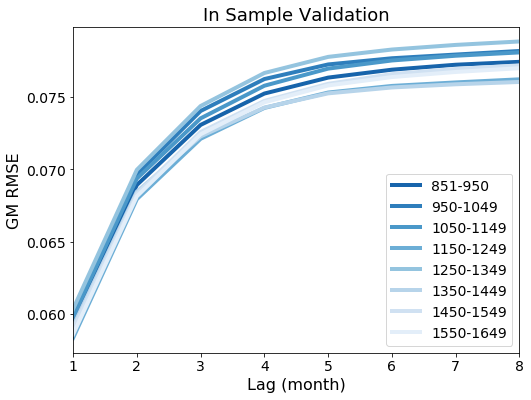

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

for i,lag in enumerate(yrstart_valid):
    ax.plot(rmse_sic_is[i,:], label=(str(yrstart_valid[i])+'-'+str(yrstart_valid[i]+nyrvalid)), 
            linewidth=4,color=colors[i])
    
ax.set_xlim(0,7)
#ax[0].set_ylim(0.059,0.09)
#ax[0].legend(bbox_to_anchor=[1,1],fontsize=14)
ax.set_ylabel('GM RMSE', fontsize=16)
ax.set_xlabel('Lag (month)', fontsize=16)
ax.set_xticklabels(lags, fontsize=14)
ax.set_title('In Sample Validation', fontsize=18)
ax.tick_params(labelsize=14)
plt.legend(loc='lower right', fontsize=14)